# Swiss Roll Classification
We begin by importing the necessary functions and the swiss roll function

In [4]:
from scripts import *
from graphs import *
from sklearn.datasets import make_swiss_roll
from sklearn.model_selection import train_test_split
#!python -m amplpy.modules activate 570845f4-0a14-4e32-824f-7b66b06a66b0


$ amplkey activate --uuid 570845f4-0a14-4e32-824f-7b66b06a66b0
Wrote license to /home/pmarg/miniconda3/envs/psd/lib/python3.10/site-packages/ampl_module_base/bin/ampl.lic
License 570845f4-0a14-4e32-824f-7b66b06a66b0 activated!
Please restart AMPL in order to start using the new license.


We generate the dataset using the swiss roll and make the target variable by cutting of by the median

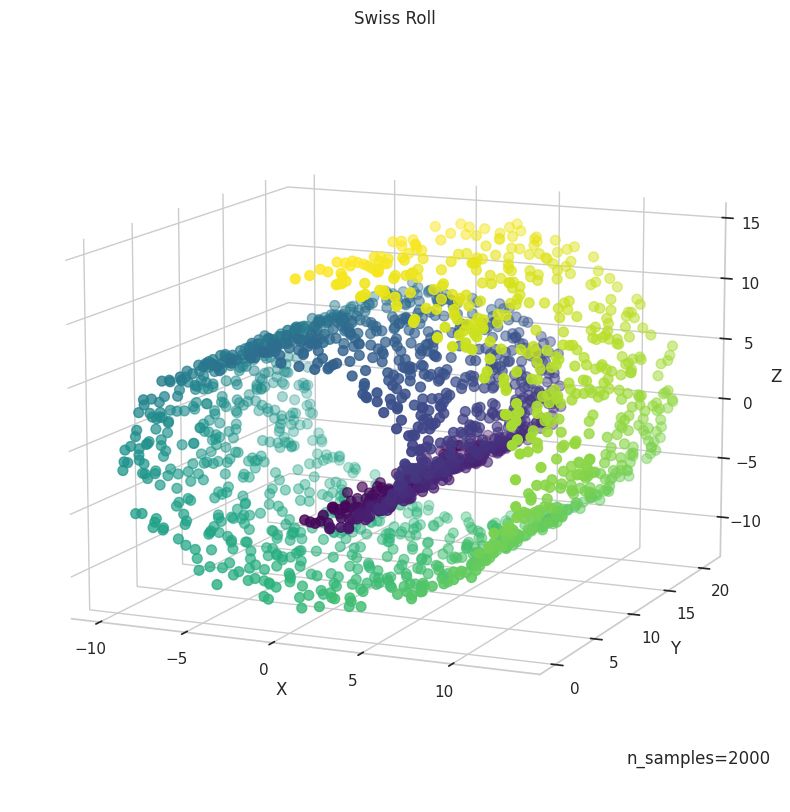

In [30]:
# plot with seaborn
sns.set(style="whitegrid", palette="muted", color_codes=True)

# load data
X, y = make_swiss_roll(n_samples=2000, noise=0.2, random_state=42)
# make figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.viridis, s=50)
ax.set_title('Swiss Roll')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(azim=-66, elev=12)
_ = ax.text2D(0.8, 0.05, s="n_samples=2000", transform=ax.transAxes)
# set white background
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

plt.show()

In [36]:
X, y = make_swiss_roll(n_samples=500, noise=0.2, random_state=42)

median = np.median(y)
for i in range(len(y)):
    if y[i] < median:
        y[i] = -1
    else:
        y[i]= 1
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5,train_size=0.5,seed=42)

TypeError: train_test_split() got an unexpected keyword argument 'seed'

In [37]:
model = SVM_ampl(nu=1, type="dual_linear",n=3,solver="ipopt")
model = model.fit(X_train,y_train)
print(model.output)

ipopt
ipopt
Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      250
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    31375

Total number of variables............................:      250
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      250
                     variables with only upper bounds: 

In [39]:
w = model.w
gamma = model.gamma

y_pred = model.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6


In [40]:
# plot the swiss roll using plotly
# set figure size
fig = px.scatter_3d(x=X_train[:,0], y=X_train[:,1], z=X_train[:,2], color=y_train)
fig.update_traces(marker=dict(size=2,
                                line=dict(width=2,      
                                color='DarkSlateGrey')),
                                selector=dict(mode='markers'))
# add the separating plane
x = np.linspace(-10, 10, 30)
y = np.linspace(0, 20, 30)
X, Y = np.meshgrid(x, y)
Z = (-w[0] * X - w[1] * Y-gamma) / w[2]
fig.add_trace(go.Surface(x=X, y=Y, z=Z, opacity=0.5))
# fig.update_layout(title="Swiss roll dataset with separating plane")
# set size
# remove cmap and colorbar
fig.update_layout(coloraxis_showscale=False)

fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=0, r=0, b=0, t=0))
# save

fig.show()

As we expected the classifier does not perform well. We try again using the gaussian kernel:

In [41]:
model_kernel = SVM_ampl(nu=1, type="dual_gaussian",n=3)
model_kernel = model_kernel.fit(X_train,y_train)

y_pred = model_kernel.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy}")

highs
predicting with gaussian kernel
Accuracy: 0.988


The performance has been greatly increased. We can increase it by tunging the parameters:

In [8]:
cv = 5
from sklearn.model_selection import cross_val_score
nu = [0.1,0.5,1,5,10]
scores = {}
for n in nu:
    model = SVM_ampl(nu=n, type="dual_gaussian",n=3,solver="ipopt")
    scores[n]=np.mean(cross_val_score(model, X_train, y_train, cv=cv))
    print(f"nu: {n} Accuracy: {scores[n]}")
    

ipopt
predicting with gaussian kernel
ipopt
predicting with gaussian kernel
ipopt
predicting with gaussian kernel
ipopt
predicting with gaussian kernel
ipopt
predicting with gaussian kernel
nu: 0.1 Accuracy: 0.508
ipopt
predicting with gaussian kernel
ipopt
predicting with gaussian kernel
ipopt
predicting with gaussian kernel
ipopt
predicting with gaussian kernel
ipopt
predicting with gaussian kernel
nu: 0.5 Accuracy: 0.916
ipopt
predicting with gaussian kernel
ipopt
predicting with gaussian kernel
ipopt
predicting with gaussian kernel
ipopt
predicting with gaussian kernel
ipopt
predicting with gaussian kernel
nu: 1 Accuracy: 0.976
ipopt
predicting with gaussian kernel
ipopt
predicting with gaussian kernel
ipopt
predicting with gaussian kernel
ipopt
predicting with gaussian kernel
ipopt
predicting with gaussian kernel
nu: 5 Accuracy: 0.9800000000000001
ipopt
predicting with gaussian kernel
ipopt
predicting with gaussian kernel
ipopt
predicting with gaussian kernel
ipopt
predicting with

In [42]:
# for each nu fit the model and measure time and get iterations
# import time for measuring time
import time
nu = [0.1,0.5,1,5,10]

times = {}
iterations = {}
accuracy = {}
for n in nu:
    model = SVM_ampl(nu=n, type="dual_gaussian",n=3,solver="ipopt")
    # measure time
    start = time.time()
    model = model.fit(X_train,y_train)
    end = time.time()
    times[n] = end-start
    iterations[n] = model.metrics["num_iterations"]
    y_pred = model.predict(X_test)
    this_accuracy = np.mean(y_pred == y_test)
    accuracy[n] = this_accuracy
    print(f"nu: {n} time: {times[n]} iterations: {iterations[n]} accuracy: {accuracy[n]}")

ipopt
predicting with gaussian kernel
nu: 0.1 time: 41.57343816757202 iterations: 18 accuracy: 0.484
ipopt
predicting with gaussian kernel
nu: 0.5 time: 39.538087129592896 iterations: 15 accuracy: 0.924
ipopt
predicting with gaussian kernel
nu: 1 time: 34.19973349571228 iterations: 13 accuracy: 0.988
ipopt
predicting with gaussian kernel
nu: 5 time: 34.402153730392456 iterations: 13 accuracy: 0.984
ipopt
predicting with gaussian kernel
nu: 10 time: 37.398186445236206 iterations: 13 accuracy: 0.984


In [27]:
# fit a svc from sklearn
from sklearn.svm import SVC
model = SVC(kernel="rbf",C=1,gamma=1/3)
model = model.fit(X_train,y_train)
y_pred = model.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy}")


Accuracy: 0.988
